# Eclipse only fitting

In this notebook, we will demonstrate `juliet`'s capability of fitting eclipse in the given dataset.

- Data used: WASP-18, TESS Sector 2 (Data can be found in the 'Data' folder)
- Model: Eclipse only (that is, transits are masked) model
- `juliet` version: `dev` version of `juliet` for which the pull request is opened ([this](https://github.com/Jayshil/juliet/tree/dev) version)

First of all, let us import necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd

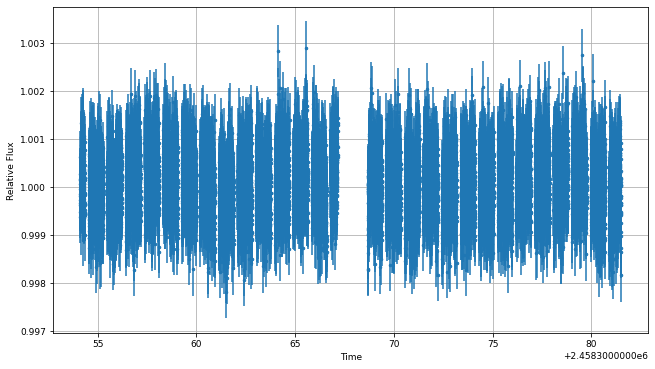

In [2]:
# Let's first load and visualise the data
tim1, fl1, fle1 = np.loadtxt(os.getcwd() + '/Data/WASP-18_only_eclipse_TESS2.dat',\
    usecols=(0,1,2), unpack=True)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.')
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.grid()

The data looks nice! Note that, in this notebook, we are only interested in eclipse fitting, all of the transits are masked.

In [3]:
# Converting data products in dictionary, so that juliet can understand it!
tim, fl, fle = {}, {}, {}
tim['TESS2'], fl['TESS2'], fle['TESS2'] = tim1, fl1, fle1

Since, we are only interested in fitting eclipse, we would,
- include priors on eclipse depth, `fp`
- NOT include LDCs in priors
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters. So, while providing priors, we will use `p_p1_TESS2` and `fp_p1_TESS2`. (Note that while analysing multiple instruments, we can share either `p_p1` or `fp_p1` or both over multiple instruments. See other notebooks for a demonstration.)
- Although `fp` is planetary _and_ instrumental parameter, the light travel correction factor is still _only_ planetary parameter, i.e., we will use `ac_p1`.

In [4]:
# Some planetary parameters (to provide priors)
# All parameters are taken from Cortés-Zuleta et al. 2020
per, per_err = 0.94145223, 0.00000024
bjd0, bjd0_err = 2456740.80560, 0.00019
rprs, rprs_err = 0.1018, 0.0011
bb, bb_err = 0.36, (0.11+0.18)/2
ar, ar_err = 3.48, 0.165
ac1 = 0.0001169                        # Computed from a = 0.02024 AU and c
## Computing transit time for the epoch from the data
cycle = round((tim1[-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc0, tc0_err = np.median(tc1), np.std(tc1)

# And priros (Note that p and fp are planetary and instrumental parameters):
par_P = ['P_p1', 't0_p1', 'p_p1_TESS2', 'b_p1', 'a_p1', 'fp_p1_TESS2', 'ac_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'normal', 'normal', 'normal', 'uniform', 'fixed', 'fixed', 'fixed']
hyper_P = [[per, per_err], [tc0, tc0_err], [rprs, rprs_err], [bb, bb_err], [ar, ar_err], [0.e-6, 500.e-6], ac1, 0., 90.]

## Instrumental and GP parameters
par_ins = ['mdilution_TESS2', 'mflux_TESS2', 'sigma_w_TESS2']
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

par_gp = ['GP_sigma_TESS2', 'GP_timescale_TESS2', 'GP_rho_TESS2']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [5]:
# And fitting it!
dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
    GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Eclipse_only')
res = dataset.fit(sampler = 'dynesty')

Detected dynesty sampler output files --- extracting from /Users/japa6985/Documents/Codes/juliet-examples/Analysis/Eclipse_only/_dynesty_NS_posteriors.pkl


In [6]:
os.system("cat Analysis/Eclipse_only/posteriors.dat")


# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414522107 	 	 0.0000002231 	 	 0.0000002236
t0_p1              	 	 2458381.7576797078 	 	 0.0003927406 	 	 0.0004094043
p_p1_TESS2         	 	 0.1016928867 	 	 0.0011222700 	 	 0.0010566217
b_p1               	 	 0.3037852824 	 	 0.0956221511 	 	 0.1119537395
a_p1               	 	 3.4386313495 	 	 0.1098902838 	 	 0.1204963936
fp_p1_TESS2        	 	 0.0003635266 	 	 0.0000237983 	 	 0.0000233613
mflux_TESS2        	 	 0.0004404702 	 	 0.0047227053 	 	 0.0047537914
sigma_w_TESS2      	 	 1.4275927353 	 	 8.5749936709 	 	 1.1966882231
GP_sigma_TESS2     	 	 0.0000227049 	 	 0.0000418938 	 	 0.0000102804
GP_timescale_TESS2 	 	 0.0081953422 	 	 0.0069564037 	 	 0.0052832543
GP_rho_TESS2       	 	 62.8460772733 	 	 25.5977478713 	 	 24.6209665117


0

The posterior of eclipse depth looks good. The median and 1-$\sigma$ credible interval are: $363.53 \pm 24$ ppm, which is within 1-$\sigma$ of what has been found in Shporer et al. 2019: $\sim 341$ ppm.

Let's now visualise our results to make sure that everything was smooth.

In [7]:
# juliet best fit model
model = res.lc.evaluate('TESS2')
gp_model = res.lc.model['TESS2']['GP']
transit_model = res.lc.model['TESS2']['deterministic']

(2458354.1115072616, 2458381.5174589776)

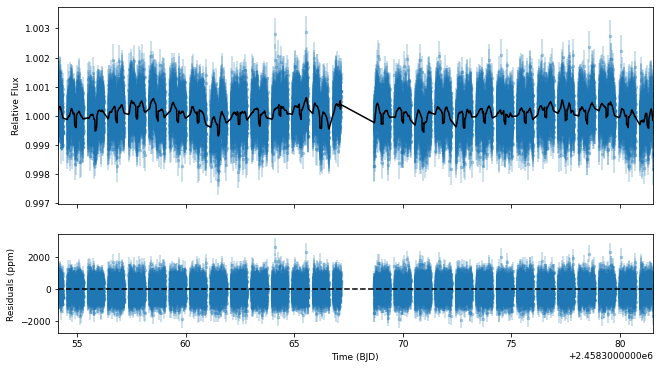

In [8]:
# Making a plot
fig = plt.figure(figsize=(16/1.5,9/1.5))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim['TESS2'], fl['TESS2'], yerr=fle['TESS2'], fmt='.', alpha=0.3)
ax1.plot(tim['TESS2'], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim['TESS2']), np.max(tim['TESS2']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim['TESS2'], (fl['TESS2']-model)*1e6, yerr=fle['TESS2']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim['TESS2']), np.max(tim['TESS2']))

This is good! Trends seem to be removed. And one can see the eclipse signal even by eye!

We can now make a phase-folded lightcurve to better visualise the results.

(0.4, 0.6)

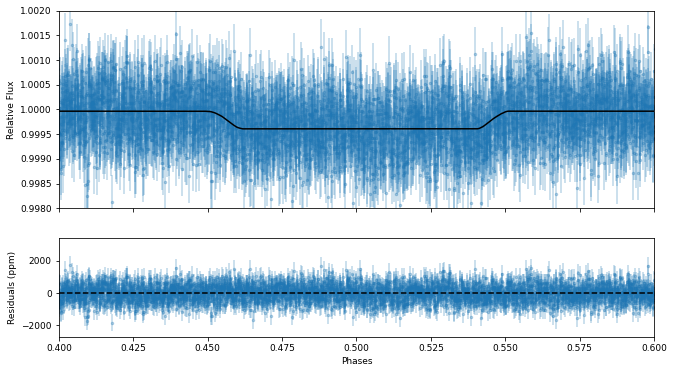

In [9]:
phs = juliet.utils.get_phases(tim['TESS2'], per, bjd0, phmin=1.0)
idx = np.argsort(phs)
# Making a plot
fig = plt.figure(figsize=(16/1.5,9/1.5))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(phs, fl['TESS2']-gp_model, yerr=fle['TESS2'], fmt='.', alpha=0.3)
ax1.plot(phs[idx], transit_model[idx], c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(0.4, 0.6)
ax1.set_ylim(0.998, 1.002)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(phs, (fl['TESS2']-model)*1e6, yerr=fle['TESS2']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Phases')
ax2.set_xlim(0.4, 0.6)

This is fantastic!